In [1]:
%load_ext autoreload

In [33]:
%autoreload 2
from UniversalUnconsciousness.data_utils import get_agent_data, get_noise_filter_info
from UniversalUnconsciousness.hdf5_utils import convert_h5_string_array
from UniversalUnconsciousness.plot_utils import load_font, plot_sensory_responses_etdc, plot_sensory_responses_acf, plot_sensory_responses_etdc_grid, plot_sensory_responses_acf_grid
from UniversalUnconsciousness.sensory_responses import cosine_sim_corrmat, get_responses_etdc, get_responses_acf, get_sensory_responses_leverOddball, get_sensory_responses_propofol
from hydra import initialize, compose
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.stats import wilcoxon
from sklearn.decomposition import PCA
import statsmodels.tsa.stattools as smt
from tqdm.auto import tqdm

plt.style.use('UniversalUnconsciousness.sci_style')
load_font()

In [5]:
with initialize(version_base="1.3", config_path="../../UniversalUnconsciousness/DeLASE_analysis/conf"):
    cfg = compose(config_name="config")

In [6]:
cfg.params.low_pass = None
cfg.params.high_pass = None

cfg.params.window = 15
cfg.params.stride = 15

In [7]:
anesthetic_agent_list = cfg.plotting.anesthetic_agent_list
img_save_dir = cfg.plotting.img_save_dir
data_save_dir = os.path.join(os.path.dirname(img_save_dir), 'sensory_responses')
os.makedirs(data_save_dir, exist_ok=True)
curve_colors = cfg.plotting.curve_colors
epoch_colors = cfg.plotting.epoch_colors
loc_roc_colors = cfg.plotting.loc_roc_colors
os.makedirs(img_save_dir, exist_ok=True)

In [8]:
agent_data = get_agent_data(cfg, use_individiual_areas=False, verbose=False)

  0%|          | 0/3 [00:00<?, ?it/s]

Only 1 valid windows could be found for section 'awake lever1' with times [-36.120676111111116, -26.045618333333337]


In [9]:
doses = ['high']
dt = 0.001
for data_class, agent in tqdm(anesthetic_agent_list):
    if agent == 'propofol':
        # leadup = 100
        # response = 650
        # trial_type = 'toneOnly'

        leadup = 250
        response = 1000
        trial_type = 'toneOnly'

        # leadup = 250
        # response = 1500
        # trial_type = 'toneOnly'
    else:

        # leadup = 100
        # response = 200
        # trial_type = 'oddball'

        leadup = 250
        response = 1000
        trial_type = 'oddball'

        # leadup = 250
        # response = 1500
        # trial_type = 'oddball'
    
    filename = f'{agent}_{data_class}_{doses}_{trial_type}_sensory_responses_{leadup}_{response}.pkl'
    if os.path.exists(os.path.join(data_save_dir, filename)):
        sensory_responses = pd.read_pickle(os.path.join(data_save_dir, filename))
    else:
        session_lists = agent_data[(data_class, agent)]['session_lists']
        noise_filter_info = agent_data[(data_class, agent)]['noise_filter_info']
        cfg.params.data_class = data_class
        iterator = tqdm(total=np.sum([len(session_lists[monkey][dose]) for monkey in session_lists.keys() for dose in session_lists[monkey].keys()]))
        sensory_responses = {}
        for monkey in session_lists.keys():
            sensory_responses[monkey] = {}
            # for dose in session_lists[monkey]:
            for dose in doses:
                sensory_responses[monkey][dose] = {}
                for session in session_lists[monkey][dose]:
                    if 'propofol' in cfg.params.data_class:
                        responses, dt = get_sensory_responses_propofol(cfg, session, noise_filter_info, trial_type, leadup, response)
                        sensory_responses[monkey][dose][session] = responses
                    else:
                        tone_lfps, dt = get_sensory_responses_leverOddball(cfg, session, noise_filter_info, trial_type, leadup, response)
                        sensory_responses[monkey][dose][session] = tone_lfps
                    iterator.update(1)
        iterator.close()
        pd.to_pickle(sensory_responses, os.path.join(data_save_dir, filename))
    agent_data[(data_class, agent)]['sensory_responses'] = sensory_responses
    agent_data[(data_class, agent)]['dt'] = dt
    agent_data[(data_class, agent)]['leadup'] = leadup
    agent_data[(data_class, agent)]['response'] = response

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

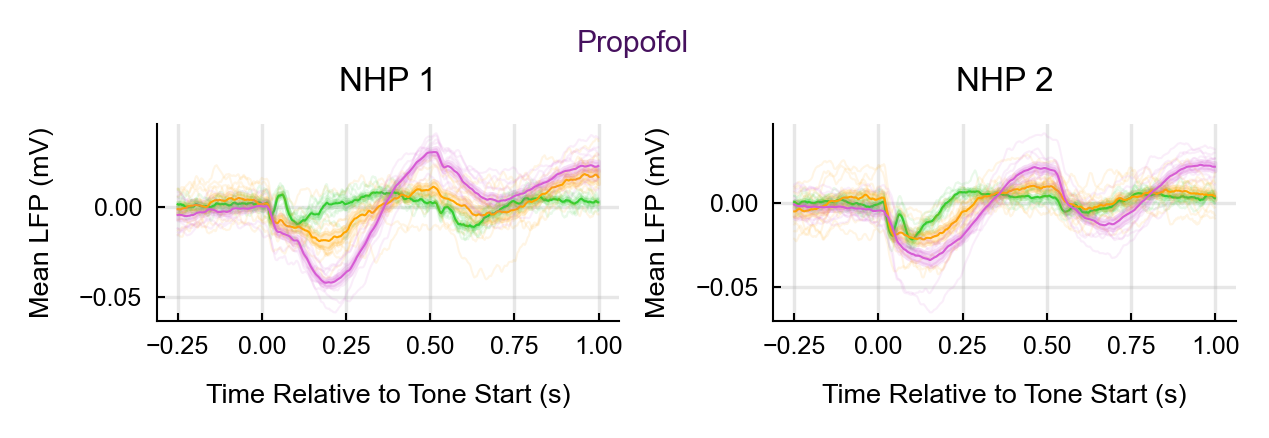

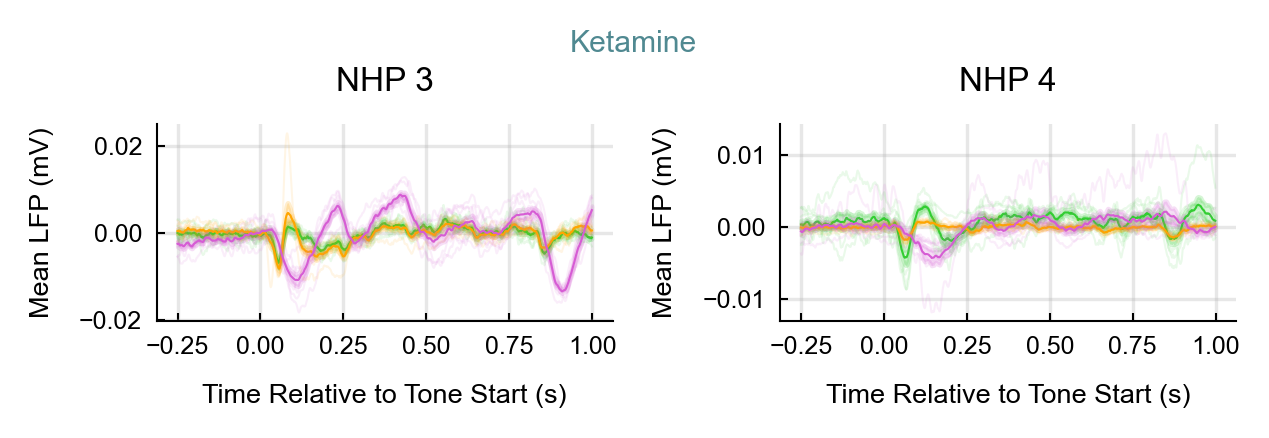

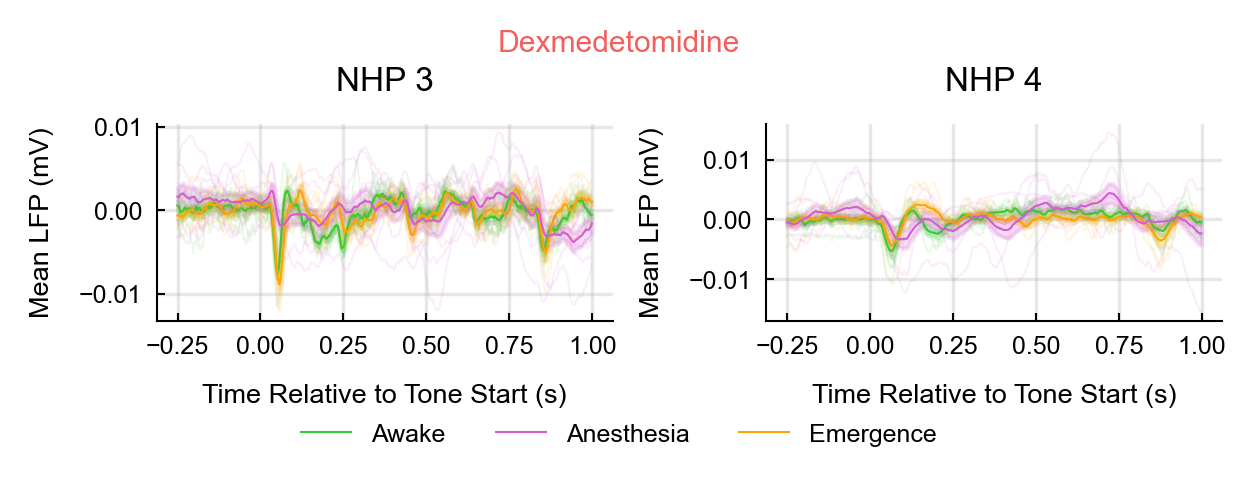

In [18]:
n_delays = 1
delay_interval = 1
min_time = None
max_time = None
plot_return_data = {}
for data_class, agent in tqdm(anesthetic_agent_list):
    # if agent in ['ketamine', 'dexmedetomidine']:
    #     min_time = -100
    #     max_time = 250
    # else:
    #     min_time = None
    #     max_time = None
    sensory_responses = agent_data[(data_class, agent)]['sensory_responses']
    leadup = agent_data[(data_class, agent)]['leadup']
    response = agent_data[(data_class, agent)]['response']
    dt = agent_data[(data_class, agent)]['dt']
    plot_return_data[(data_class, agent)] = plot_sensory_responses_etdc(
        agent, 
        curve_colors,
        epoch_colors,
        sensory_responses,
        leadup,
        response, 
        dt=dt, 
        n_delays=n_delays, 
        delay_interval=delay_interval, 
        plot_legend=True if 'dex' in agent else False, 
        save_path=os.path.join(img_save_dir, f'{agent}_sensory_responses_leverresponsetime_{response}_{min_time}_{max_time}.pdf'), 
        dims=1, 
        use_mean=True, 
        min_time=min_time, 
        max_time=max_time,
    )

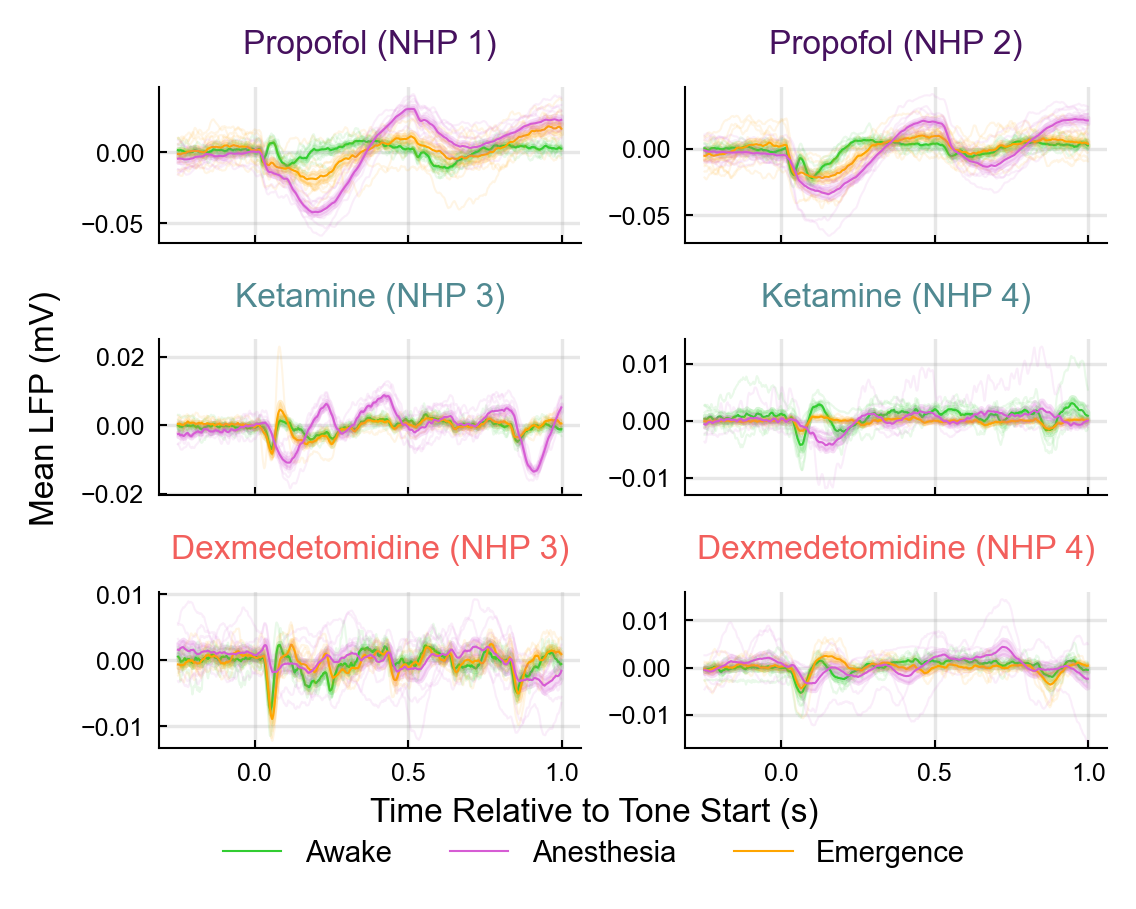

In [31]:
grid_save_path = os.path.join(
    img_save_dir,
    f"sensory_responses_etdc_grid_{n_delays}_{delay_interval}_{min_time}_{max_time}.pdf"
)

_ = plot_sensory_responses_etdc_grid(
    cfg=cfg,
    agent_data=agent_data,            # dict keyed by (data_class, agent)
    curve_colors=curve_colors,
    epoch_colors=epoch_colors,
    data_class=None,                  # or a single class for all
    data_class_by_agent=None,         # or dict agent -> data_class
    n_delays=n_delays,
    delay_interval=delay_interval,
    min_time=min_time,
    max_time=max_time,
    figsize=(4, 3),
    save_path=grid_save_path,
    use_mean=True,
    dims=1,
    dose='high',                      # pick 'high' or 'low' as desired
    plot_legend_by_agent={'dexmedetomidine': True, 'ketamine': False, 'propofol': False}
)

In [ ]:
_ = plot_sensory_responses_acf_grid(
    cfg=cfg,
    agent_data=agent_data,
    curve_colors=curve_colors,
    epoch_colors=epoch_colors,
    dose='high',
    plot_legend_by_agent={'dexmedetomidine': True, 'ketamine': False, 'propofol': False},
    save_path=grid_save_path,
    # ... other ACF-specific parameters
)

  0%|          | 0/3 [00:00<?, ?it/s]

Computing ACF:   0%|          | 0/63 [00:00<?, ?it/s]

Computing ACF:   0%|          | 0/48 [00:00<?, ?it/s]

Computing ACF:   0%|          | 0/48 [00:00<?, ?it/s]

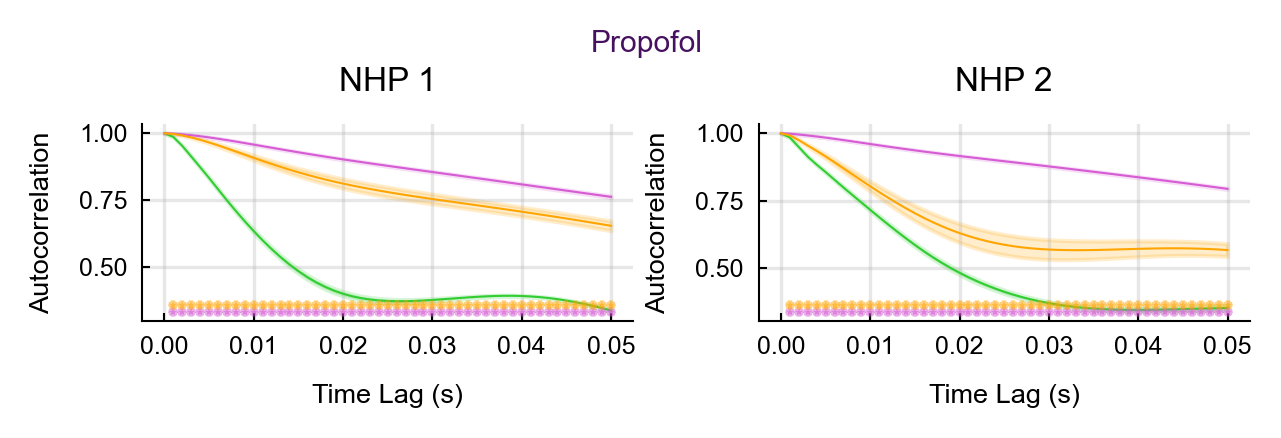

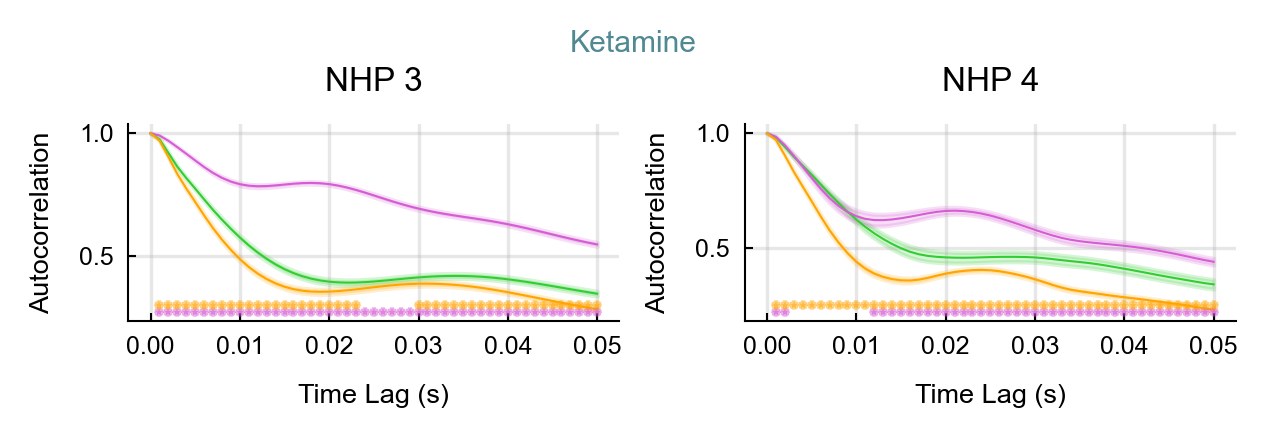

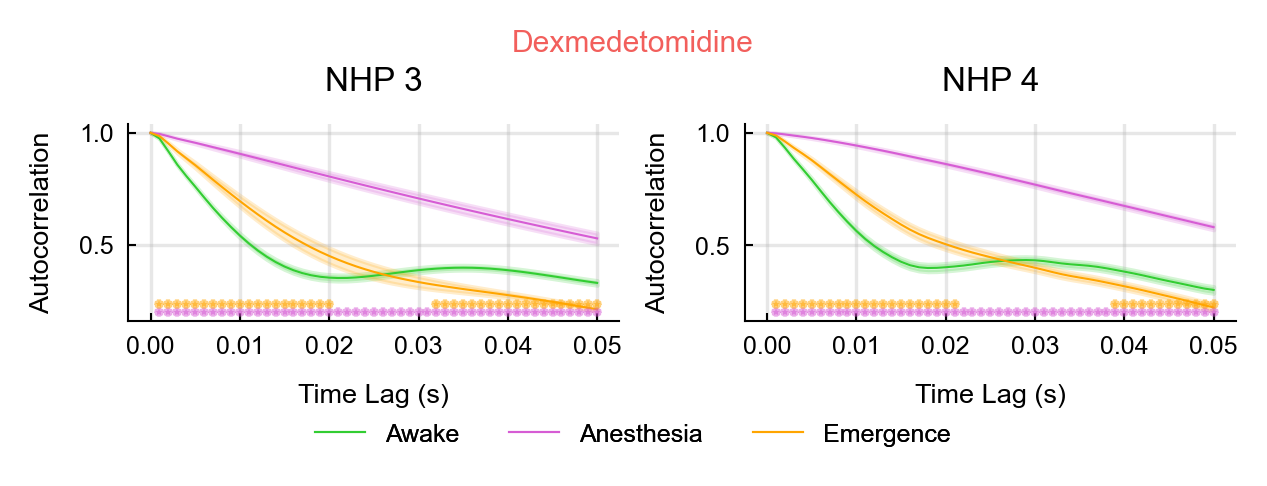

In [8]:
n_delays = 1
delay_interval = 1
plot_return_data = {}
for data_class, agent in tqdm(anesthetic_agent_list):
    sensory_responses = agent_data[(data_class, agent)]['sensory_responses']
    leadup = agent_data[(data_class, agent)]['leadup']
    response = agent_data[(data_class, agent)]['response']
    dt = agent_data[(data_class, agent)]['dt']
    plot_return_data[(data_class, agent)] = plot_sensory_responses_acf(
        agent,
        curve_colors,
        epoch_colors,
        sensory_responses,
        leadup,
        response,
        dt=dt,
        n_delays=n_delays,
        delay_interval=delay_interval,
        plot_legend=True if 'dex' in agent else False,
        method='individual',
        n_ac_pts=None,
        verbose=True,
        save_path=os.path.join(img_save_dir, f'{agent}_sensory_responses_acf_{response}.pdf'),
        data_save_dir=data_save_dir
    )

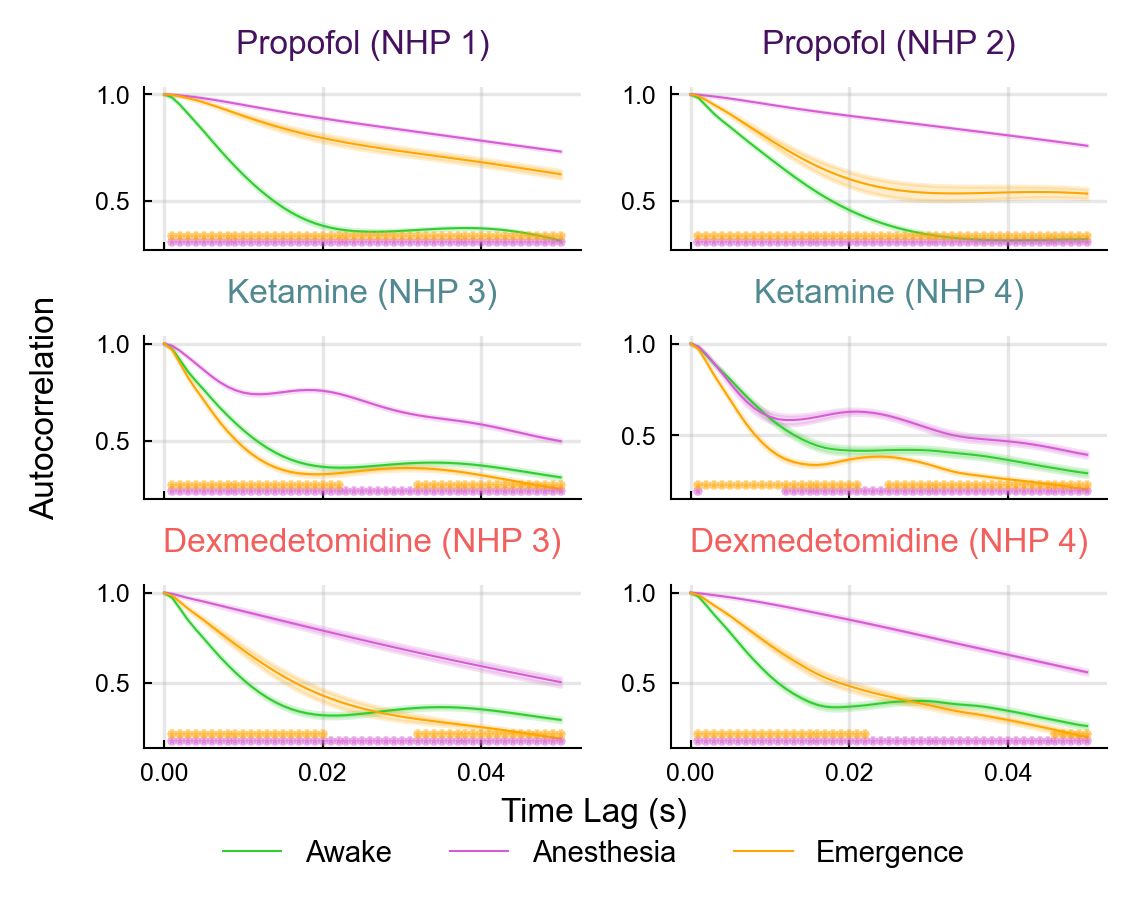

In [35]:
n_delays = 1
delay_interval = 1

grid_save_path = os.path.join(
    img_save_dir,
    f"sensory_responses_acf_grid_{n_delays}_{delay_interval}.pdf"
)

_ = plot_sensory_responses_acf_grid(
    cfg=cfg,
    agent_data=agent_data,            # dict keyed by (data_class, agent)
    curve_colors=curve_colors,
    epoch_colors=epoch_colors,
    data_class=None,                  # or a single class for all
    data_class_by_agent=None,         # or dict agent -> data_class
    n_delays=n_delays,
    delay_interval=delay_interval,
    figsize=(4, 3),
    save_path=grid_save_path,
    method='individual',
    use_mean=False,
    n_lags=50,
    n_ac_pts=None,
    verbose=True,
    data_save_dir=data_save_dir,
    dose='high',                      # pick 'high' or 'low' as desired
    plot_legend_by_agent={'dexmedetomidine': True, 'ketamine': False, 'propofol': False}
)
